In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import time
from datetime import datetime
import numpy as np

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from dataset import PalindromeDataset
from vanilla_rnn import VanillaRNN
from lstm import LSTM

In [38]:
class Config(object):
    def __init__(self):
        self.model_type = "RNN"
        self.input_length = 10
        self.input_dim = 1
        self.num_classes = 10
        self.num_hidden = 128
        self.batch_size = 128
        self.learning_rate = 0.001
        self.train_steps = 10000
        self.max_norm = 10.0
        self.device = "cuda:0"


In [39]:
def test_single_prediction_lstm(config):
    device = torch.device(config.device)
    model = LSTM(config.input_length, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device).to(device)
    dataset = PalindromeDataset(config.input_length + 1)
    data_loader = DataLoader(dataset, config.batch_size, num_workers=1)
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        print(batch_inputs.shape)
        print(batch_targets.shape)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        print('input',batch_inputs[0])
        print('truth',batch_targets[0])
        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs, 1)
        print('prediction',predicted[0])
        accuracy = (predicted[0] == batch_targets[0]).sum().item()
        print('accuracy', accuracy)
        break

def test_single_prediction_rnn(config):
    device = torch.device(config.device)
    model = VanillaRNN(config.input_length, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device)
    dataset = PalindromeDataset(config.input_length + 1)
    data_loader = DataLoader(dataset, config.batch_size, num_workers=1)
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        print(batch_inputs.shape)
        print(batch_targets.shape)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        print('input',batch_inputs[0])
        print('truth',batch_targets[0])
        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs, 1)
        print('prediction',predicted[0])
        accuracy = (predicted[0] == batch_targets[0]).sum().item()
        print('accuracy', accuracy)
        break

In [40]:
def experiment_memorization_lstm(config):
    device = torch.device(config.device)
    
    avg_accuracies = []
    
    for seq_length in range(5, 11):
        # Initialize the model

        model = LSTM(seq_length - 1, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device).to(device)
        
        # Initialize the dataset and data loader
        dataset = PalindromeDataset(seq_length)
        data_loader = DataLoader(dataset, config.batch_size, num_workers=1)
        
        # Setup the loss and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)
        
        # Training loop
        total_accuracy = 0.0
        count = 0
        for step, (batch_inputs, batch_targets) in enumerate(data_loader):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
                
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
                
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.max_norm)
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == batch_targets).sum().item() / config.batch_size
            total_accuracy += accuracy
            count += 1
            if step % 10 == 0:
                print(
                        "[{}] Train Step {:04d}/{:04d}, Batch Size = {}"
                        " Accuracy = {:.2f}, Loss = {:.3f}, seq_length = {}".format(
                            datetime.now().strftime("%Y-%m-%d %H:%M"),
                            step,
                            config.train_steps,
                            config.batch_size,
                            accuracy,
                            loss,
                            seq_length,
                        )
                    )

            if step == config.train_steps:
                break
        
        avg_accuracy = total_accuracy / count
        avg_accuracies.append(avg_accuracy)   
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(5, 11), avg_accuracies, marker='o')
    plt.xlabel('Palindrome Length')
    plt.ylabel('Accuracy')
    plt.title(f'LSTM Memorization Capability: Accuracy vs Palindrome Length with {config.train_steps} training steps')
    plt.grid(True)
    plt.savefig('lstm_memorization_accuracy.png')
    plt.show()

In [41]:
def experiment_memorization_rnn(config):
    device = torch.device(config.device)
    
    avg_accuracies = []
    
    for seq_length in range(5, 11):
        # Initialize the model
        model = VanillaRNN(seq_length - 1, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device).to(device)
        
        # Initialize the dataset and data loader
        dataset = PalindromeDataset(seq_length)
        data_loader = DataLoader(dataset, config.batch_size, num_workers=1)
        
        # Setup the loss and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)
        total_accuracy = 0.0
        count = 0
        # Training loop
        for step, (batch_inputs, batch_targets) in enumerate(data_loader):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
                
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
                
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.max_norm)
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == batch_targets).sum().item() / config.batch_size # fixme
            
            total_accuracy += accuracy
            count += 1
                
            if step % 10 == 0:
                print(
                        "[{}] Train Step {:04d}/{:04d}, Batch Size = {}"
                        " Accuracy = {:.2f}, Loss = {:.3f}, seq_length = {}".format(
                            datetime.now().strftime("%Y-%m-%d %H:%M"),
                            step,
                            config.train_steps,
                            config.batch_size,
                            accuracy,
                            loss,
                            seq_length,
                        )
                    )

            if step == config.train_steps:
                # If you receive a PyTorch data-loader error, check this bug report:
                # https://github.com/pytorch/pytorch/pull/9655
                break
        avg_accuracy = total_accuracy / count
        avg_accuracies.append(avg_accuracy)        

    plt.figure(figsize=(10, 6))
    plt.plot(range(5, 11), avg_accuracies, marker='o')
    plt.xlabel('Palindrome Length')
    plt.ylabel('Accuracy')
    plt.title(f'RNN Memorization Capability: Avg. Accuracy vs Palindrome Length with {config.train_steps} training steps')
    plt.grid(True)
    plt.savefig("accuracy_vs_palindrome_length.png")
    plt.show()

In [42]:
def train(config):

    assert config.model_type in ("RNN", "LSTM")

    # Initialize the device which to run the model on
    device = torch.device(config.device)

    print (config)
    # Initialize the model that we are going to use
    if config.model_type == "RNN":
        model = VanillaRNN(config.input_length, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device)
    elif config.model_type == "LSTM":
        model = LSTM(config.input_length, config.input_dim, config.num_hidden, config.num_classes, config.batch_size, device)

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(config.input_length + 1)
    data_loader = DataLoader(dataset, config.batch_size, num_workers=1)

    # Setup the loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()  # fixme
    optimizer = torch.optim.RMSprop(model.parameters(),lr=config.learning_rate)  # fixme

    for step, (batch_inputs, batch_targets) in enumerate(data_loader):

        # Only for time measurement of step through network
        t1 = time.time()

        # Add more code here ...

        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        optimizer.zero_grad()
        loss.backward()
        ############################################################################
        # QUESTION: what happens here and why?
        ############################################################################
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config.max_norm)
        ############################################################################
        optimizer.step()
        # Add more code here ...

        #loss = loss = criterion(outputs, batch_targets)  # fixme
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == batch_targets).sum().item() / config.batch_size # fixme
        
        # Just for time measurement
        t2 = time.time()
        examples_per_second = config.batch_size / float(t2 - t1)

        if step % 10 == 0:

            print(
                "[{}] Train Step {:04d}/{:04d}, Batch Size = {}, Examples/Sec = {:.2f}, "
                "Accuracy = {:.2f}, Loss = {:.3f}".format(
                    datetime.now().strftime("%Y-%m-%d %H:%M"),
                    step,
                    config.train_steps,
                    config.batch_size,
                    examples_per_second,
                    accuracy,
                    loss,
                )
            )

        if step == config.train_steps:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break

    print("Done training.")

In [43]:
# Train the model
config_rnn = Config()
config_lstm = Config()
config_lstm.model_type = "LSTM"

train(config_rnn) # run this to test exercise 1.2




C:\Users\Ilir\AppData\Local\Temp\ipykernel_14848\4000413927.py:39: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config.max_norm)


[2024-06-26 18:12] Train Step 0000/10000, Batch Size = 128, Examples/Sec = 12818.04, Accuracy = 0.09, Loss = 17.321
[2024-06-26 18:12] Train Step 0010/10000, Batch Size = 128, Examples/Sec = 16001.64, Accuracy = 0.08, Loss = 9.391
[2024-06-26 18:12] Train Step 0020/10000, Batch Size = 128, Examples/Sec = 13227.66, Accuracy = 0.12, Loss = 5.865
[2024-06-26 18:12] Train Step 0030/10000, Batch Size = 128, Examples/Sec = 16000.68, Accuracy = 0.11, Loss = 4.987
[2024-06-26 18:12] Train Step 0040/10000, Batch Size = 128, Examples/Sec = 12798.18, Accuracy = 0.11, Loss = 6.012
[2024-06-26 18:12] Train Step 0050/10000, Batch Size = 128, Examples/Sec = 12799.40, Accuracy = 0.12, Loss = 5.104
[2024-06-26 18:12] Train Step 0060/10000, Batch Size = 128, Examples/Sec = 14218.36, Accuracy = 0.10, Loss = 5.081
[2024-06-26 18:12] Train Step 0070/10000, Batch Size = 128, Examples/Sec = 18278.32, Accuracy = 0.16, Loss = 4.601
[2024-06-26 18:12] Train Step 0080/10000, Batch Size = 128, Examples/Sec = 1279

[2024-06-26 18:14] Train Step 0000/10000, Batch Size = 128 Accuracy = 0.12, Loss = 13.031, seq_length = 5
[2024-06-26 18:14] Train Step 0010/10000, Batch Size = 128 Accuracy = 0.12, Loss = 6.178, seq_length = 5
[2024-06-26 18:14] Train Step 0020/10000, Batch Size = 128 Accuracy = 0.16, Loss = 4.508, seq_length = 5
[2024-06-26 18:14] Train Step 0030/10000, Batch Size = 128 Accuracy = 0.12, Loss = 3.750, seq_length = 5
[2024-06-26 18:14] Train Step 0040/10000, Batch Size = 128 Accuracy = 0.09, Loss = 3.604, seq_length = 5
[2024-06-26 18:14] Train Step 0050/10000, Batch Size = 128 Accuracy = 0.16, Loss = 3.191, seq_length = 5
[2024-06-26 18:14] Train Step 0060/10000, Batch Size = 128 Accuracy = 0.23, Loss = 2.482, seq_length = 5
[2024-06-26 18:14] Train Step 0070/10000, Batch Size = 128 Accuracy = 0.14, Loss = 2.774, seq_length = 5
[2024-06-26 18:14] Train Step 0080/10000, Batch Size = 128 Accuracy = 0.20, Loss = 2.404, seq_length = 5
[2024-06-26 18:14] Train Step 0090/10000, Batch Size =

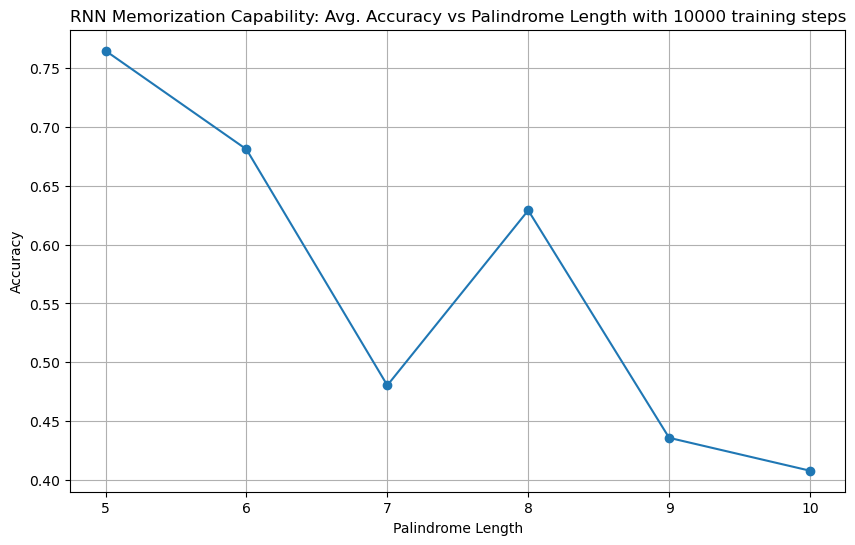

In [44]:
experiment_memorization_rnn(config_rnn) # run this to test exercise 1.3

In [45]:
test_single_prediction_rnn(config_rnn)

torch.Size([128, 10])
torch.Size([128])
input tensor([0., 7., 9., 4., 4., 3., 4., 4., 9., 7.], device='cuda:0')
truth tensor(0, device='cuda:0')
prediction tensor(4, device='cuda:0')
accuracy 0


[2024-06-26 18:23] Train Step 0000/10000, Batch Size = 128 Accuracy = 0.16, Loss = 7.079, seq_length = 5
[2024-06-26 18:23] Train Step 0010/10000, Batch Size = 128 Accuracy = 0.43, Loss = 2.044, seq_length = 5
[2024-06-26 18:23] Train Step 0020/10000, Batch Size = 128 Accuracy = 0.58, Loss = 1.282, seq_length = 5
[2024-06-26 18:23] Train Step 0030/10000, Batch Size = 128 Accuracy = 0.62, Loss = 1.036, seq_length = 5
[2024-06-26 18:23] Train Step 0040/10000, Batch Size = 128 Accuracy = 0.68, Loss = 0.901, seq_length = 5
[2024-06-26 18:23] Train Step 0050/10000, Batch Size = 128 Accuracy = 0.69, Loss = 0.839, seq_length = 5
[2024-06-26 18:23] Train Step 0060/10000, Batch Size = 128 Accuracy = 0.72, Loss = 0.795, seq_length = 5
[2024-06-26 18:23] Train Step 0070/10000, Batch Size = 128 Accuracy = 0.75, Loss = 0.650, seq_length = 5
[2024-06-26 18:23] Train Step 0080/10000, Batch Size = 128 Accuracy = 0.84, Loss = 0.565, seq_length = 5
[2024-06-26 18:23] Train Step 0090/10000, Batch Size = 

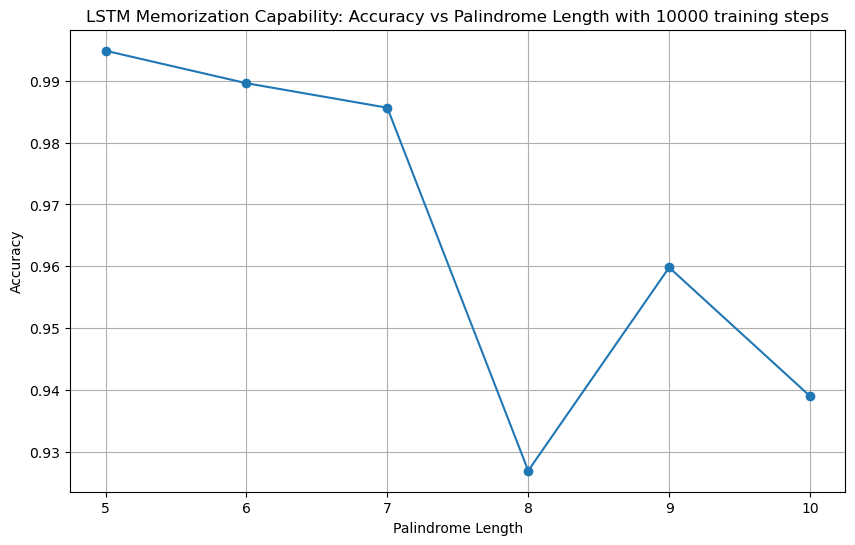

In [46]:
experiment_memorization_lstm(config_lstm) # run this to test exercise 1.6
# you see that it reaches almost perfect accuracy for T=5

In [47]:
test_single_prediction_lstm(config_lstm)

torch.Size([128, 10])
torch.Size([128])
input tensor([6., 7., 4., 3., 9., 5., 9., 3., 4., 7.], device='cuda:0')
truth tensor(6, device='cuda:0')
prediction tensor(9, device='cuda:0')
accuracy 0


In [48]:
#try to achieve near perfect accuracy with RNN for T=5
config_rnn.input_length = 5
config_rnn.train_steps = 20000
train(config_rnn) 


C:\Users\Ilir\AppData\Local\Temp\ipykernel_14848\4000413927.py:39: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config.max_norm)


[2024-06-26 18:43] Train Step 0000/20000, Batch Size = 128, Examples/Sec = 12798.79, Accuracy = 0.06, Loss = 13.676
[2024-06-26 18:43] Train Step 0010/20000, Batch Size = 128, Examples/Sec = 18286.42, Accuracy = 0.11, Loss = 6.727
[2024-06-26 18:43] Train Step 0020/20000, Batch Size = 128, Examples/Sec = 18285.17, Accuracy = 0.06, Loss = 5.567
[2024-06-26 18:43] Train Step 0030/20000, Batch Size = 128, Examples/Sec = 21333.18, Accuracy = 0.09, Loss = 4.297
[2024-06-26 18:43] Train Step 0040/20000, Batch Size = 128, Examples/Sec = 25599.41, Accuracy = 0.09, Loss = 4.654
[2024-06-26 18:43] Train Step 0050/20000, Batch Size = 128, Examples/Sec = 21329.79, Accuracy = 0.12, Loss = 3.345
[2024-06-26 18:43] Train Step 0060/20000, Batch Size = 128, Examples/Sec = 25584.77, Accuracy = 0.11, Loss = 3.085
[2024-06-26 18:43] Train Step 0070/20000, Batch Size = 128, Examples/Sec = 21330.64, Accuracy = 0.15, Loss = 2.793
[2024-06-26 18:43] Train Step 0080/20000, Batch Size = 128, Examples/Sec = 1828

# Answers to the exercises

## 1.4) 

One of the problems that SGD faces is getting stuck in local minima. RMSProp, Adam and momentum try to solve this problem.
Momentum helps because it integrates the gradient of the previous steps with the current gradient so that the model can converge faster.
Also the accumulated gradient / velocity can help "knock/nudge" the gradient a little forward in order for it not to fall in local minimas.
RMSProp adapts the learning rate for each parameter separately based on the magnitude of the gradients. 
By doing this it allows for more significant updates for the parameters that aren't frequently updated. 
It helps with mitigating vanishing learning rate in SGD.
Adam combines both these concepts (it uses adaptive learning rates and momentum). Using this the model can converge faster and also Adam does bias correction.
By fighting biases it achieves better accuracy.

## 1.5)
### a)

g(t):

Purpose -> Creates a possible new candidate vector that can be added to the cell state vector.

Non-linearity -> tanh 

Reason for using tanh -> To limit the range of the output to [-1, 1] so that there are no exploding gradients.

i(t):

Purpose -> How much the candidate vector g(t) should be added to the cell state vector.

Non-linearity -> sigmoid

Reason for using sigmoid -> Useful for gating/allow varying degrees of new information.

f(t):

Purpose -> This gate decides how much of the previous cell state should be kept/forgotten.

Non-linearity -> sigmoid

Reason for using sigmoid -> Smooth choice between forgeting (0) and keeping (1) information from the previous cell state.

o(t):

Purpose -> How much of the cell state should be outputted and used for the next hidden state.

Non-linearity -> sigmoid

Reason for using sigmoid -> Smooth choice between 0 and 1 for controlling amount of cell information to be exposed at each step.

### b)

All weights and biases for gates:

W_gx with dimensions n×d

W_gh with dimensions nxn

b_g with dimension n

W_ix with dimensions nxd

W_ih with dimensions nxn

b_i with dimension n

W_fx with dimensions n×d

W_fh with dimensions n×n

b_f with dimension n

W_ox with dimensions n×d

W_oh with dimensions nxn

b_o with dimension n


All weights and biases for the output layer (k=number of classes):

W_ph with dimensions k×n

b_p with dimension k

So we have:

4 times n×d

4 times nxn

4 times n

1 time kxn

1 time k

Total number of trainable parameters = 4nd + 4n^2 + 4n + kn + k 



## 1.6)

In general the training for RNN is faster than for LSTM (less multiplications of matrices).

Accuracy for Short Sequences (T = 5):
Vanilla RNN: Near-perfect accuracy for short sequences.
LSTM: Near-perfect accuracy for short sequences.

Accuracy for Longer Sequences (T > 5):
Vanilla RNN: Accuracy drops significantly as sequence length increases due to the inability to capture long-term dependencies. 
LSTM: Maintains high accuracy for longer sequences, effectively capturing long-term dependencies and demonstrating superior performance.

Reasons can be:
- Vanishing/Exploding gradients because of BPTT in RNNs
- Limited memory due to recurrency in RNNs
- RNN has fewer parameters than LSTM